# Experiment: Latent Variable Sampling in a Graph-Based Model

## Objective
The goal of this experiment is to explore the probabilistic modeling component of the **Graph-EFM** framework by generating and sampling the latent variable \( Z \) in a toy graph-based setting. This allows us to:
- Understand how uncertainty is modeled and propagated in a graph.
- Experiment with different parameters (e.g., variance of \( Z \), graph structure).
- Visualize the impact of \( Z \) on the final output.

---

## Key Components

### 1. **Graph Construction**
- A toy graph is created with `num_nodes` nodes and random features.
- Edges connect every node to every other node (fully connected graph).

### 2. **GNN Encoder**
- A Graph Neural Network (GNN) encodes node features into the mean of the latent variable \( \mu_Z \).
- The GNN uses **GCNConv** layers from PyTorch Geometric.

### 3. **Latent Variable \( Z \)**
- \( Z \) is sampled from a Gaussian distribution \( \mathcal{N}(\mu_Z, \sigma_Z^2) \).
- The reparameterization trick is used for differentiable sampling:
  \[
  Z = \mu_Z + \sigma_Z \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, 1)
  \]

### 4. **Decoder**
- A simple Multi-Layer Perceptron (MLP) maps \( Z \) back to an output space (e.g., a weather variable).

### 5. **Visualization**
- Heatmaps are used to visualize:
  - The mean of \( Z \) (`mu_Z`).
  - Sampled \( Z \).
  - Decoded output.

---

## Code Overview

```python
# Key steps in the code:
# 1. Create a toy graph with random features.
# 2. Encode node features into mu_Z using a GNN.
# 3. Sample Z from a Gaussian distribution.
# 4. Decode Z into an output.
# 5. Visualize mu_Z, Z, and the decoded output.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np


In [3]:

class GNNEncoder(nn.Module):
    '''Graph Neural Network (GNN) for encoding'''
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GNNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, latent_dim)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Decoder(nn.Module):
    '''simple decoder to map Z back to output space'''
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, z):
        return self.mlp(z)


### Toy graph setup


In [4]:

def create_toy_graph(num_nodes, input_dim):
    edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous()
    x = torch.randn(num_nodes, input_dim)  # Random node features
    return Data(x=x, edge_index=edge_index)


In [5]:

# Parameters
input_dim = 10  # Input feature dimension for each node
hidden_dim = 16  # Hidden dimension in GNN
latent_dim = 5   # Dimension of latent variable Z
output_dim = 1   # Output dimension (e.g., a single weather variable)
num_nodes = 10   # Number of nodes in the graph
sigma_Z = 1.0    # Fixed standard deviation for Z


In [6]:
# Create toy graph
graph = create_toy_graph(num_nodes, input_dim)

# Initialize encoder and decoder
encoder = GNNEncoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, output_dim)

# Forward pass: encode, sample Z, and decode
mu_Z = encoder(graph.x, graph.edge_index)  # Encode to get mu_Z
epsilon = torch.randn_like(mu_Z)           # Sample noise
Z = mu_Z + sigma_Z * epsilon               # Reparameterization trick
output = decoder(Z)                        # Decode Z to output


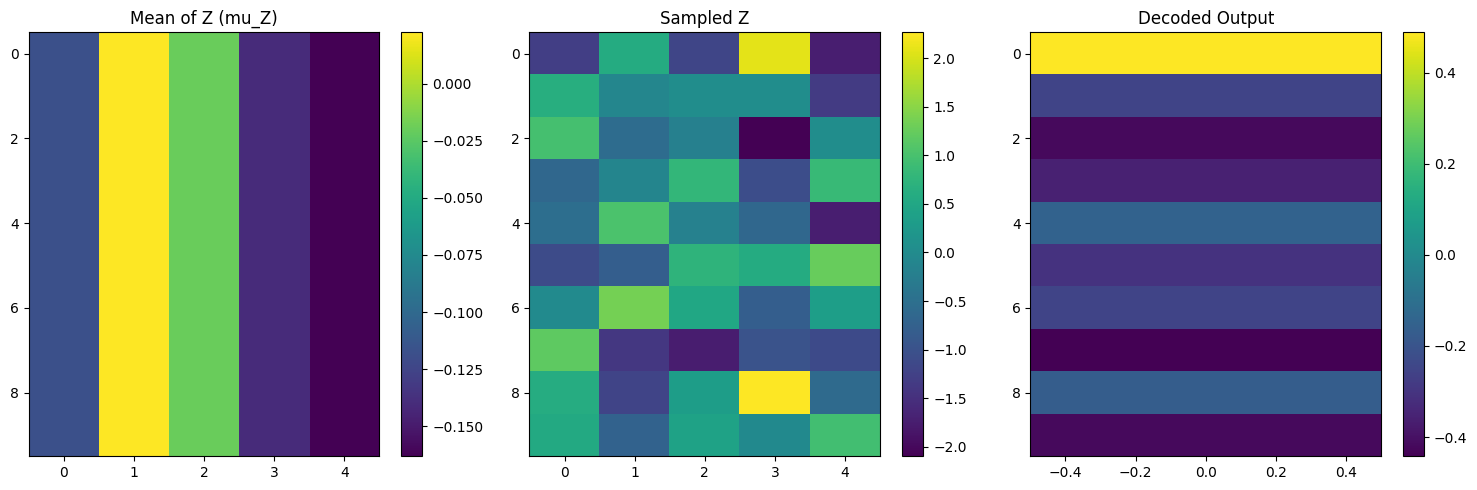

Mean of Z (mu_Z):
 [[-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]]
Sampled Z:
 [[-1.290394    0.58208835 -1.1928798   2.080845   -1.727859  ]
 [ 0.6419918  -0.08921107  0.04506375  0.04431844 -1.3465053 ]
 [ 0.9862526  -0.5549104  -0.20221432 -2.096143    0.0334803 ]
 [-0.6384627  -0.11238224  0.79750663 -1.0617903   0.83772874]
 [-0.52791923  1.0296586  -0.1782112  -0.6394065  -1.7241313 ]
 [-1.1060135  -0.796055

In [7]:

def visualize_results(mu_Z, Z, output):
    plt.figure(figsize=(15, 5))
    
    #  mu_Z (mean of Z)
    plt.subplot(1, 3, 1)
    plt.title("Mean of Z (mu_Z)")
    plt.imshow(mu_Z.detach().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar()
    
    #  sampled Z
    plt.subplot(1, 3, 2)
    plt.title("Sampled Z")
    plt.imshow(Z.detach().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar()
    
    #  decoded output
    plt.subplot(1, 3, 3)
    plt.title("Decoded Output")
    plt.imshow(output.detach().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

visualize_results(mu_Z, Z, output)

#  values for debugging
print("Mean of Z (mu_Z):\n", mu_Z.detach().numpy())
print("Sampled Z:\n", Z.detach().numpy())
print("Decoded Output:\n", output.detach().numpy())

# Expérience : Modélisation Spatiotemporelle avec un Graph



## Objectif
L'objectif de cette expérience est d'étendre le modèle probabiliste basé sur un graphe pour inclure des dimensions **spatiales** et **temporelles**. Cela permet de :
- Modéliser l'évolution des variables dans le temps et l'espace.
- Explorer comment l'incertitude se propage à travers le graphe spatiotemporel.
- Visualiser les prédictions et l'incertitude à différents pas de temps.



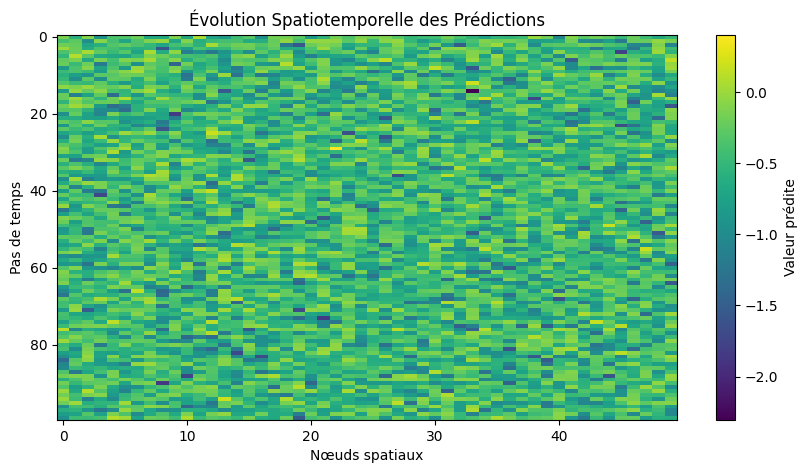

In [14]:


## Code Adapté pour un Graph Spatiotemporel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Encodeur GNN pour un graph spatiotemporel
class SpatioTemporalGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(SpatioTemporalGNN, self).__init__()
        self.conv_spatial = GCNConv(input_dim, hidden_dim)  # Convolution spatiale
        self.conv_temporal = GCNConv(hidden_dim, latent_dim)  # Convolution temporelle
        
    def forward(self, x, edge_index_spatial, edge_index_temporal):
        # Propagation spatiale
        x = F.relu(self.conv_spatial(x, edge_index_spatial))
        # Propagation temporelle
        x = self.conv_temporal(x, edge_index_temporal)
        return x

# Création d'un graph spatiotemporel
def create_spatiotemporal_graph(num_nodes, num_timesteps, input_dim, mean=0.0, std=1.0):
    # Arêtes spatiales (voisinage géographique)
    edge_index_spatial = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous()
    
    # Arêtes temporelles (évolution dans le temps)
    edge_index_temporal = torch.tensor([[i, i + num_nodes] for i in range(num_nodes * (num_timesteps - 1))], dtype=torch.long).t().contiguous()
    
    # Caractéristiques des nœuds (aléatoires pour l'instant)
    x = torch.normal(mean=mean, std=std, size=(num_nodes * num_timesteps, input_dim))
    
    return Data(x=x, edge_index_spatial=edge_index_spatial, edge_index_temporal=edge_index_temporal)

# Paramètres
input_dim = 10  # Dimension des caractéristiques d'entrée
hidden_dim = 16  # Dimension cachée du GNN
latent_dim = 5   # Dimension de la variable latente Z
num_nodes = 50    # Nombre de nœuds spatiaux
num_timesteps = 100  # Nombre de pas de temps

# Création du graph spatiotemporel
graph = create_spatiotemporal_graph(num_nodes, num_timesteps, input_dim)

# Initialisation de l'encodeur et du décodeur
encoder = SpatioTemporalGNN(input_dim, hidden_dim, latent_dim)
decoder = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))

# Encodage, échantillonnage de Z et décodage
mu_Z = encoder(graph.x, graph.edge_index_spatial, graph.edge_index_temporal)
epsilon = torch.randn_like(mu_Z)
Z = mu_Z + 1.0 * epsilon  # sigma_Z = 1.0
output = decoder(Z)

# Visualisation des résultats
def visualize_spatiotemporal(output, num_nodes, num_timesteps):
    output = output.view(num_timesteps, num_nodes).detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(output, cmap='viridis', aspect='auto')
    plt.colorbar(label='Valeur prédite')
    plt.xlabel('Nœuds spatiaux')
    plt.ylabel('Pas de temps')
    plt.title('Évolution Spatiotemporelle des Prédictions')
    plt.show()

visualize_spatiotemporal(output, num_nodes, num_timesteps)

Expérience : latent_dim=2, sigma_Z=0.5, num_nodes=5, num_timesteps=3


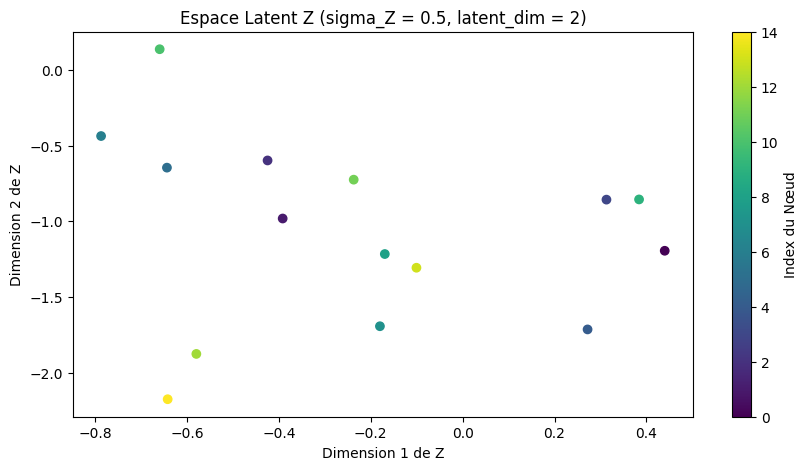

Expérience : latent_dim=2, sigma_Z=0.5, num_nodes=5, num_timesteps=5


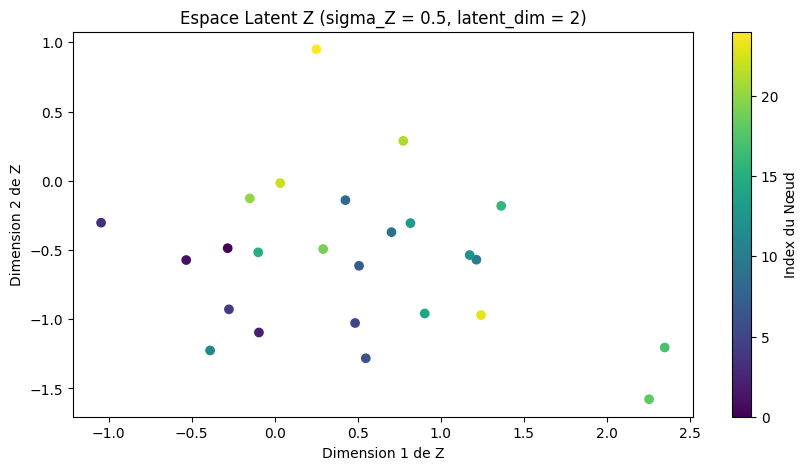

Expérience : latent_dim=2, sigma_Z=0.5, num_nodes=10, num_timesteps=3


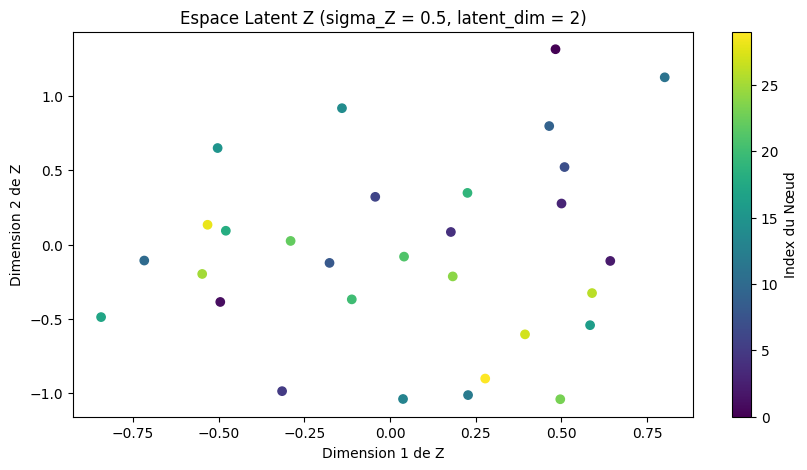

Expérience : latent_dim=2, sigma_Z=0.5, num_nodes=10, num_timesteps=5


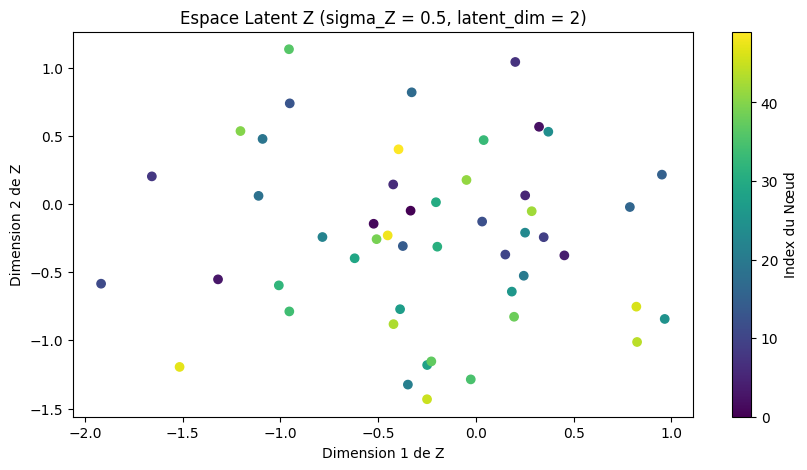

Expérience : latent_dim=2, sigma_Z=1.0, num_nodes=5, num_timesteps=3


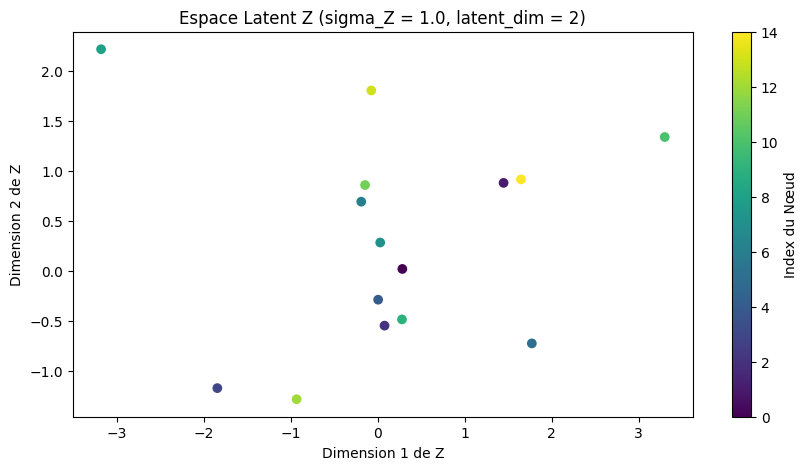

Expérience : latent_dim=2, sigma_Z=1.0, num_nodes=5, num_timesteps=5


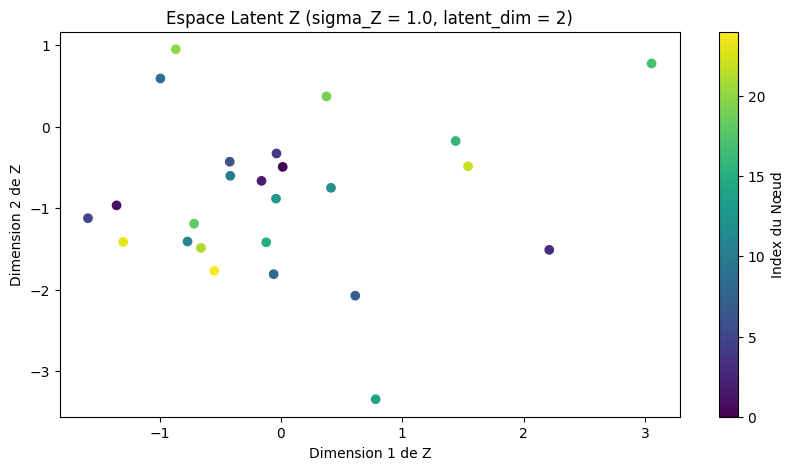

Expérience : latent_dim=2, sigma_Z=1.0, num_nodes=10, num_timesteps=3


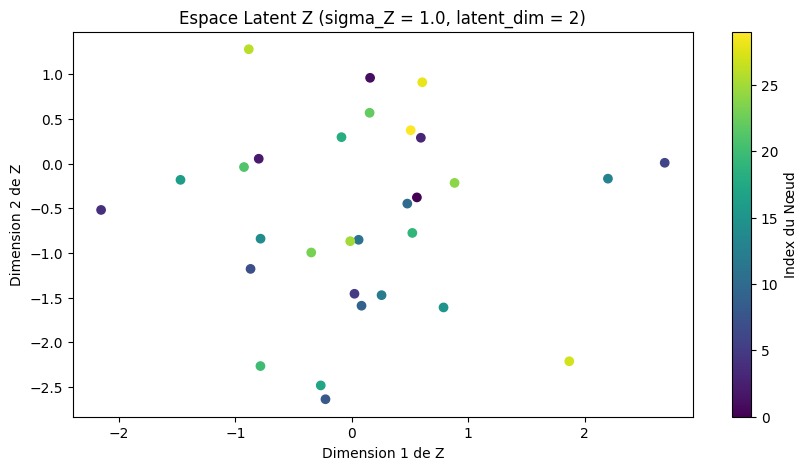

Expérience : latent_dim=2, sigma_Z=1.0, num_nodes=10, num_timesteps=5


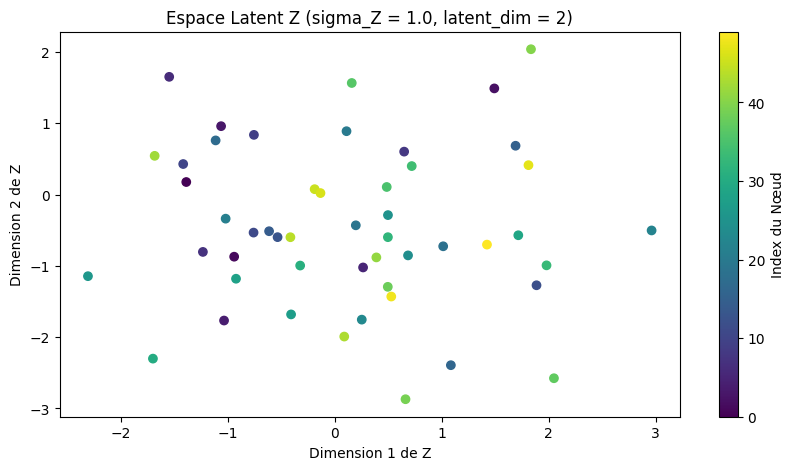

Expérience : latent_dim=2, sigma_Z=2.0, num_nodes=5, num_timesteps=3


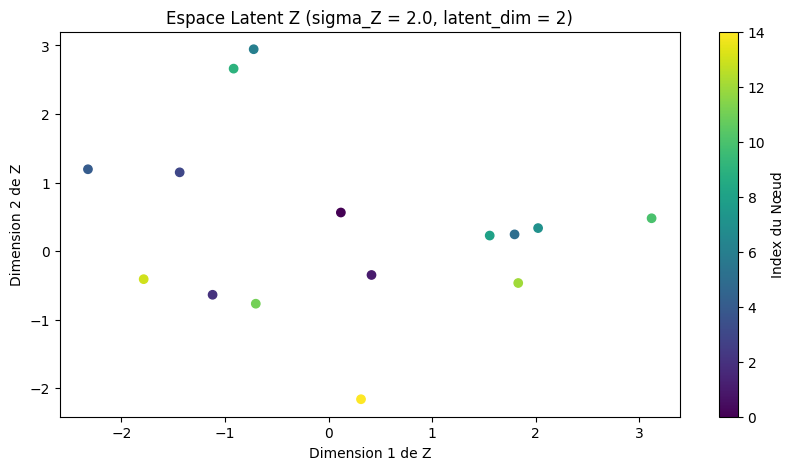

Expérience : latent_dim=2, sigma_Z=2.0, num_nodes=5, num_timesteps=5


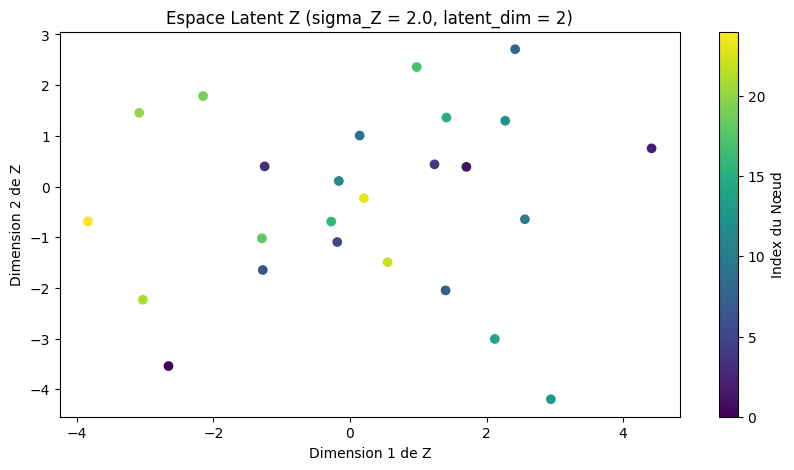

Expérience : latent_dim=2, sigma_Z=2.0, num_nodes=10, num_timesteps=3


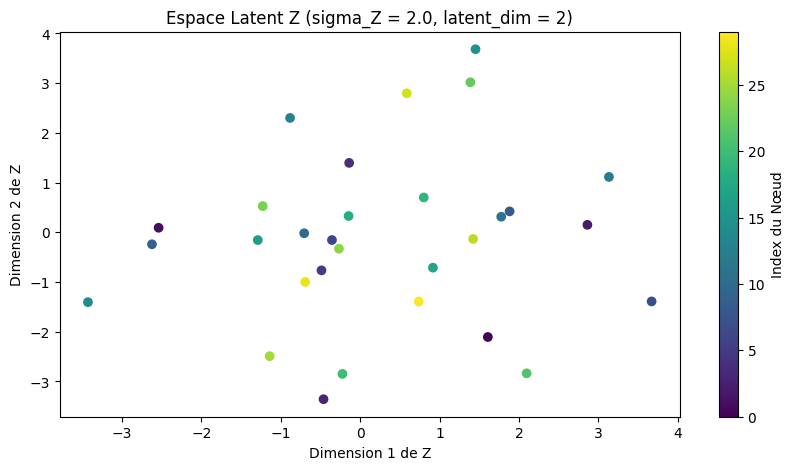

Expérience : latent_dim=2, sigma_Z=2.0, num_nodes=10, num_timesteps=5


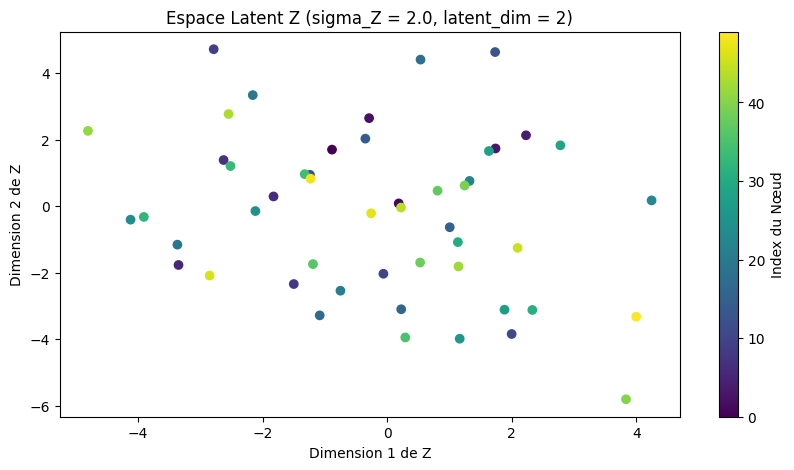

Expérience : latent_dim=5, sigma_Z=0.5, num_nodes=5, num_timesteps=3


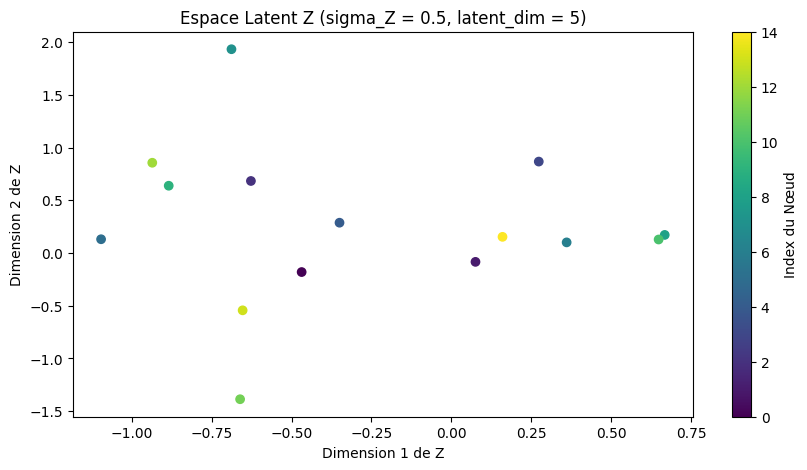

Expérience : latent_dim=5, sigma_Z=0.5, num_nodes=5, num_timesteps=5


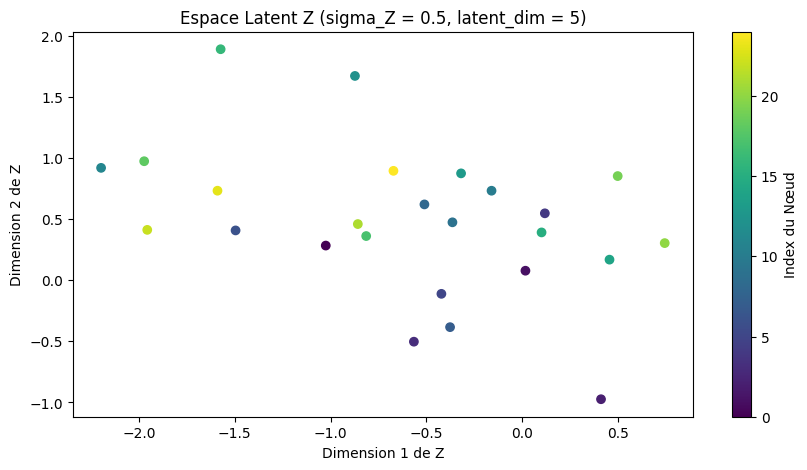

Expérience : latent_dim=5, sigma_Z=0.5, num_nodes=10, num_timesteps=3


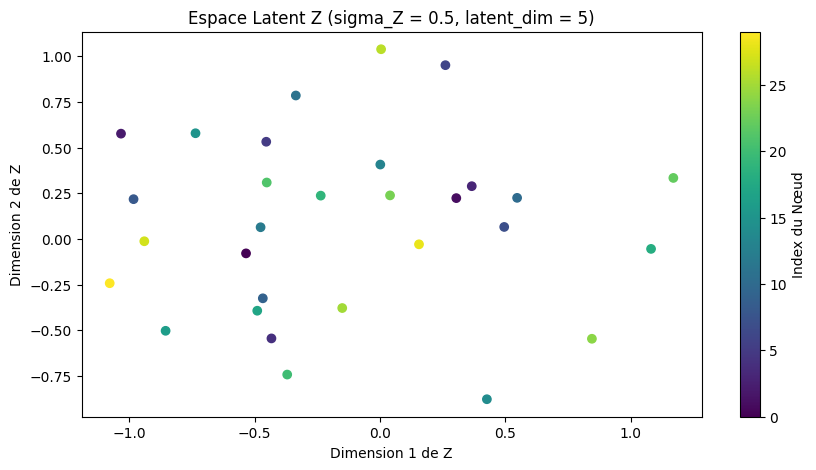

Expérience : latent_dim=5, sigma_Z=0.5, num_nodes=10, num_timesteps=5


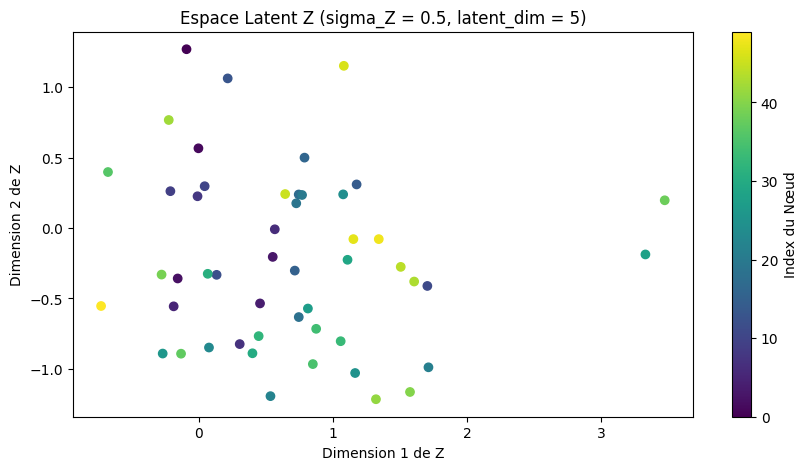

Expérience : latent_dim=5, sigma_Z=1.0, num_nodes=5, num_timesteps=3


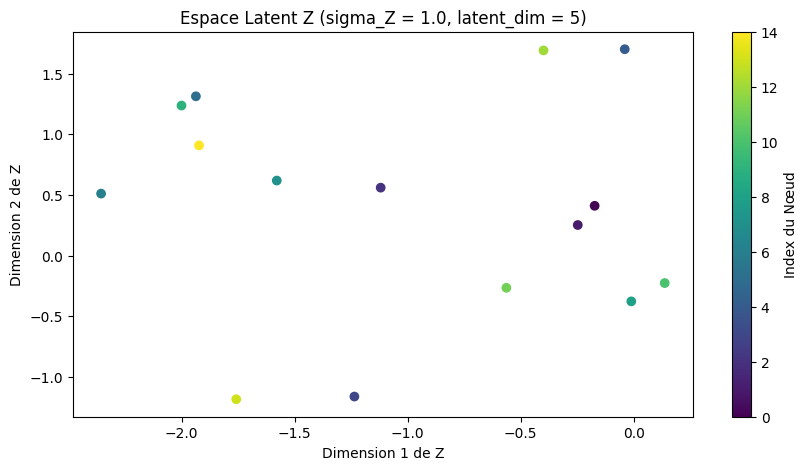

Expérience : latent_dim=5, sigma_Z=1.0, num_nodes=5, num_timesteps=5


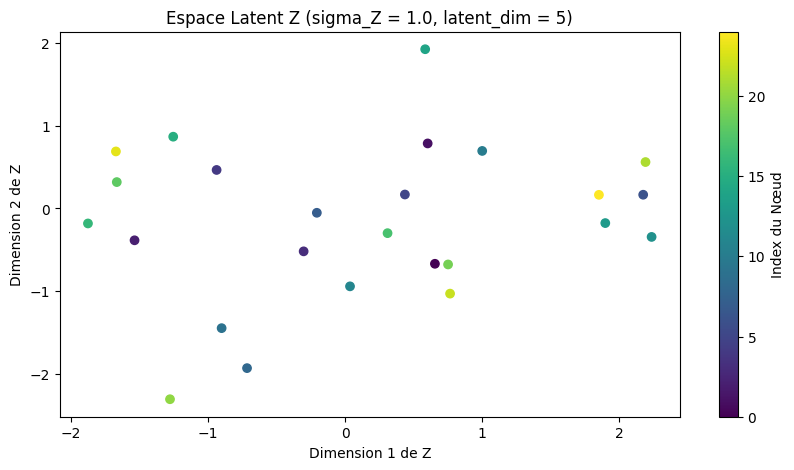

Expérience : latent_dim=5, sigma_Z=1.0, num_nodes=10, num_timesteps=3


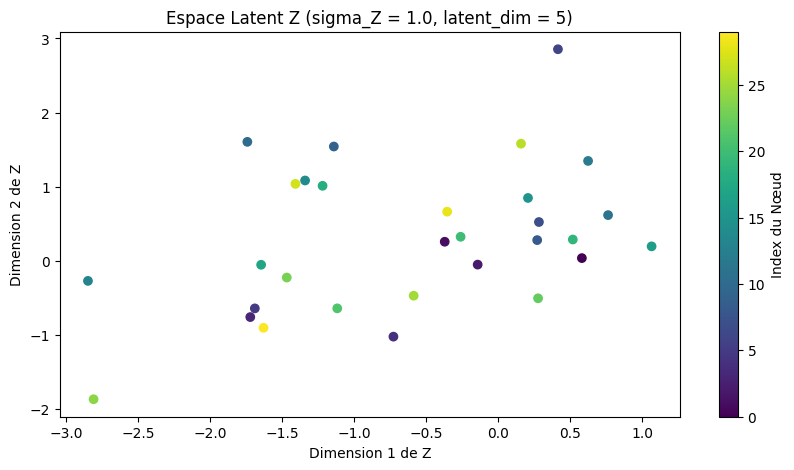

Expérience : latent_dim=5, sigma_Z=1.0, num_nodes=10, num_timesteps=5


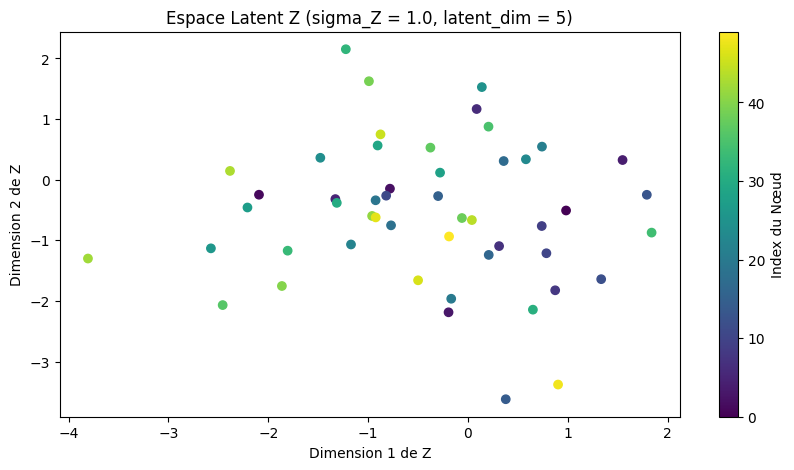

Expérience : latent_dim=5, sigma_Z=2.0, num_nodes=5, num_timesteps=3


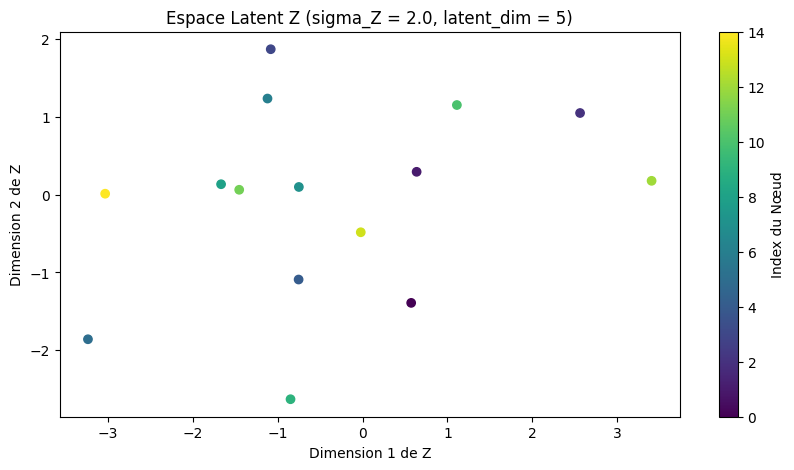

Expérience : latent_dim=5, sigma_Z=2.0, num_nodes=5, num_timesteps=5


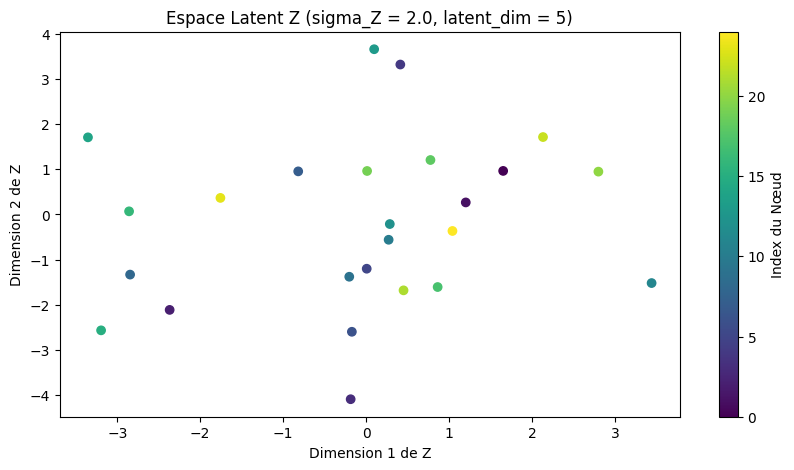

Expérience : latent_dim=5, sigma_Z=2.0, num_nodes=10, num_timesteps=3


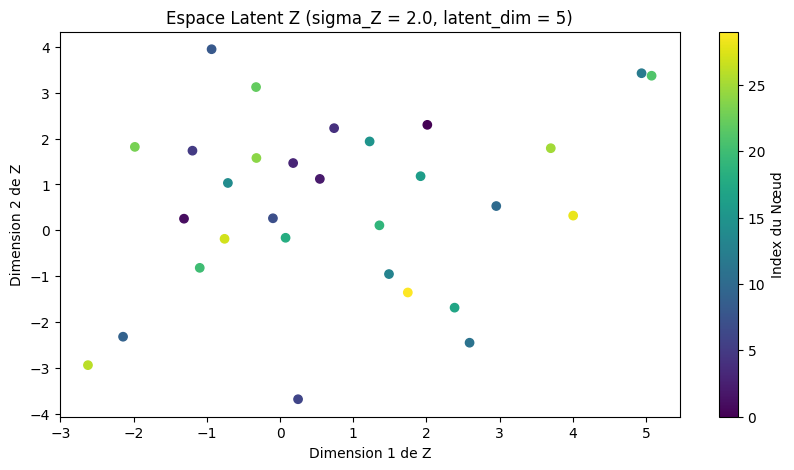

Expérience : latent_dim=5, sigma_Z=2.0, num_nodes=10, num_timesteps=5


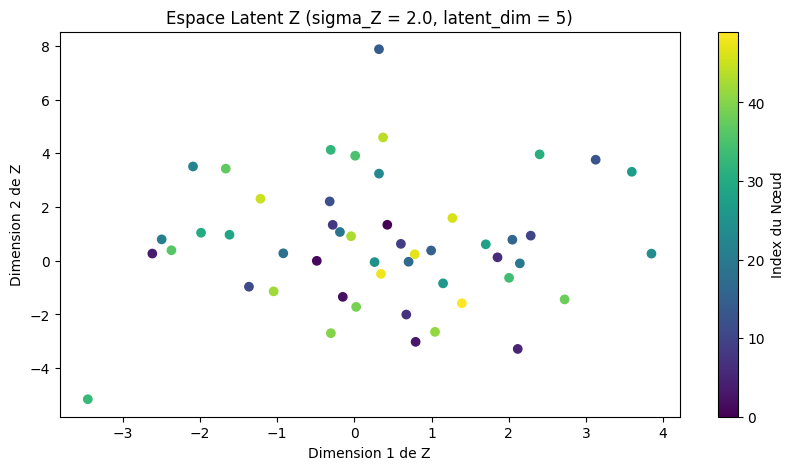

Expérience : latent_dim=10, sigma_Z=0.5, num_nodes=5, num_timesteps=3


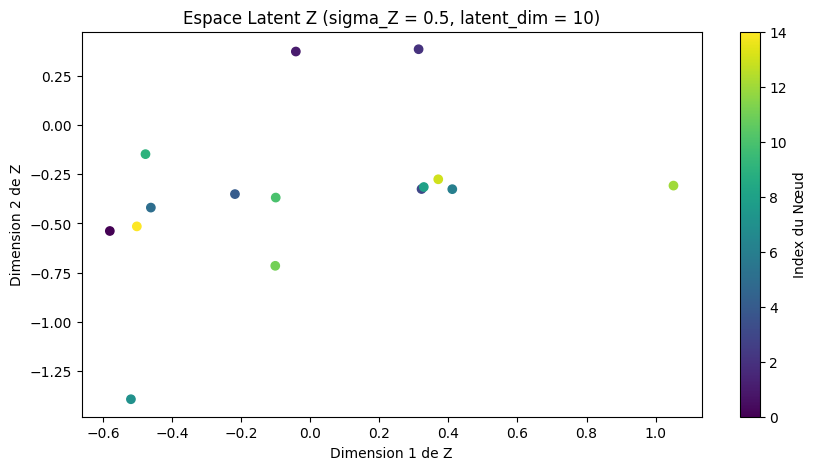

Expérience : latent_dim=10, sigma_Z=0.5, num_nodes=5, num_timesteps=5


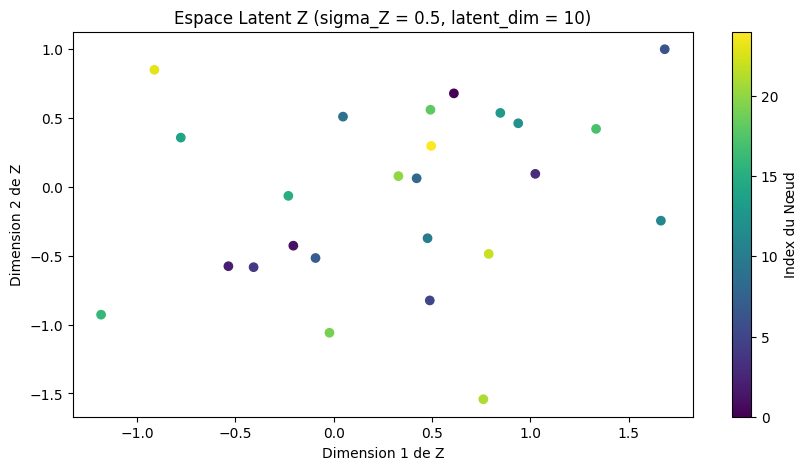

Expérience : latent_dim=10, sigma_Z=0.5, num_nodes=10, num_timesteps=3


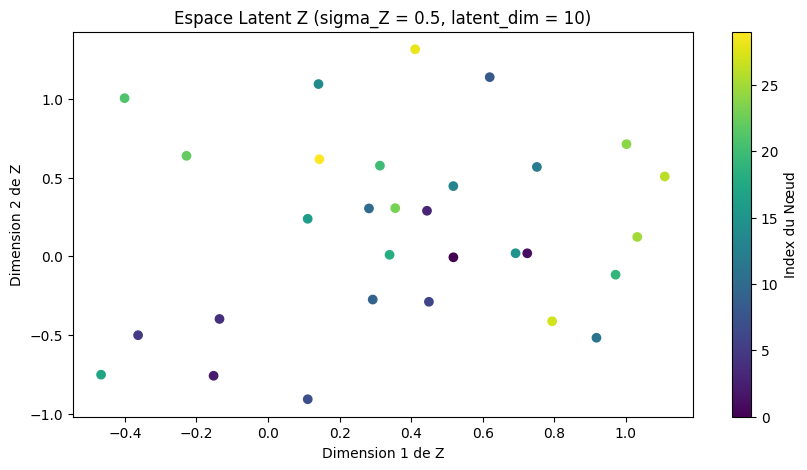

Expérience : latent_dim=10, sigma_Z=0.5, num_nodes=10, num_timesteps=5


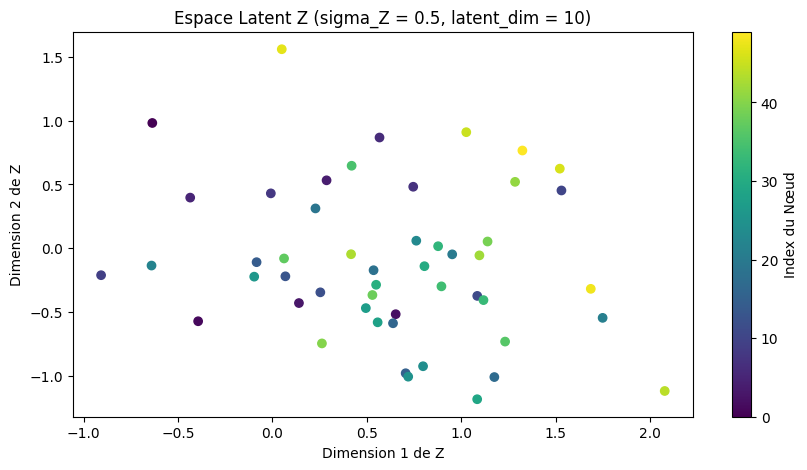

Expérience : latent_dim=10, sigma_Z=1.0, num_nodes=5, num_timesteps=3


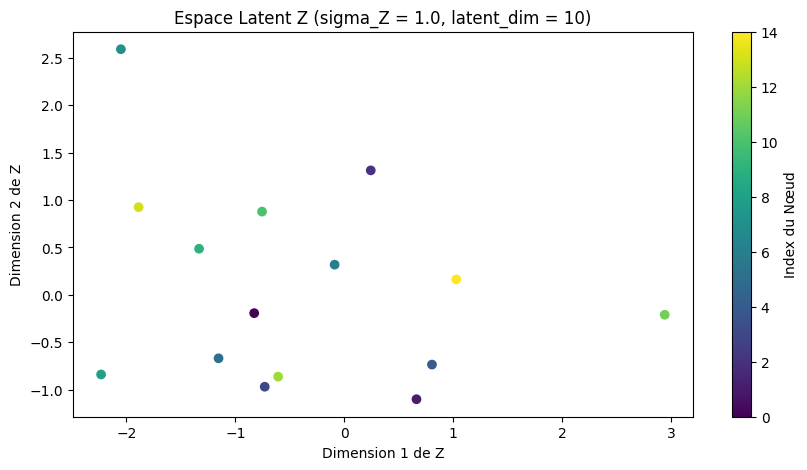

Expérience : latent_dim=10, sigma_Z=1.0, num_nodes=5, num_timesteps=5


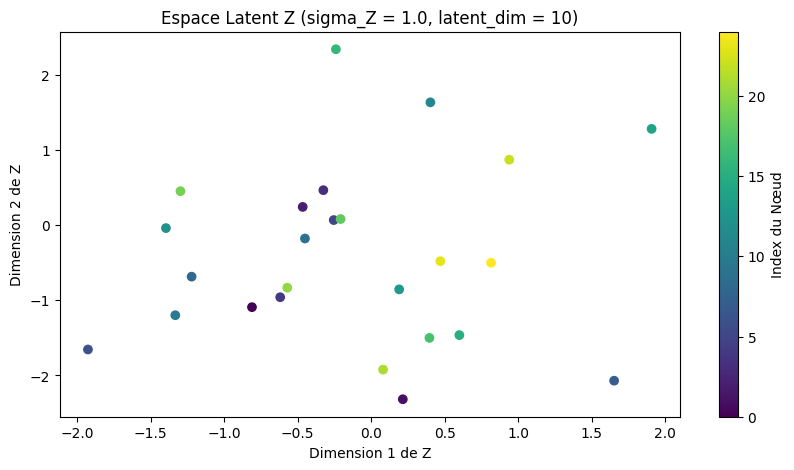

Expérience : latent_dim=10, sigma_Z=1.0, num_nodes=10, num_timesteps=3


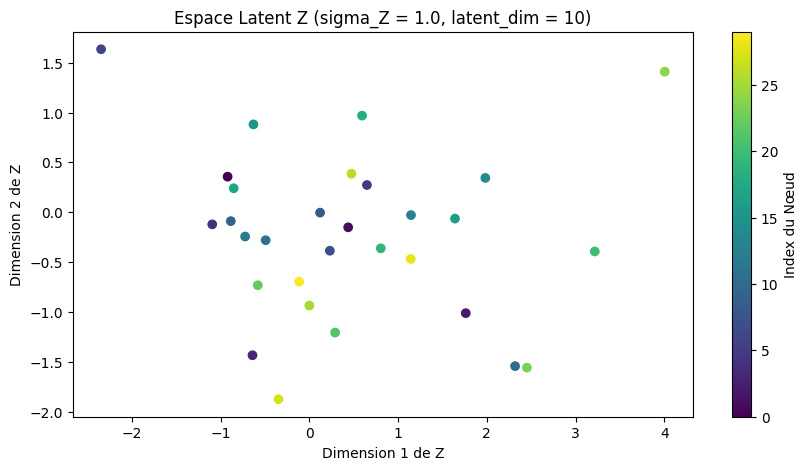

Expérience : latent_dim=10, sigma_Z=1.0, num_nodes=10, num_timesteps=5


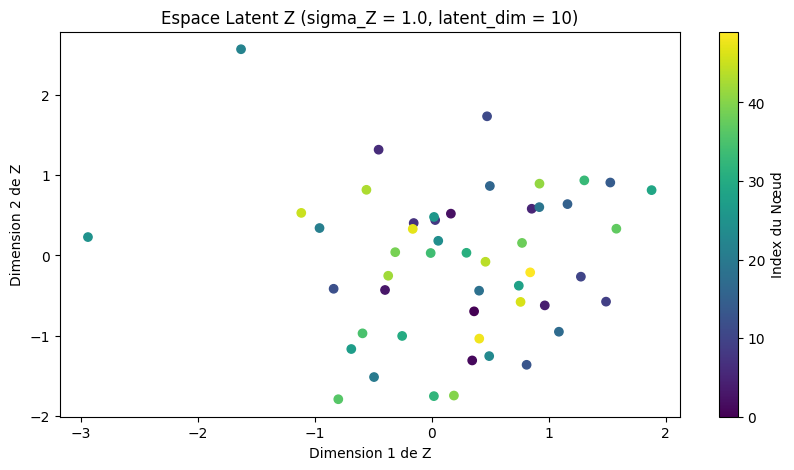

Expérience : latent_dim=10, sigma_Z=2.0, num_nodes=5, num_timesteps=3


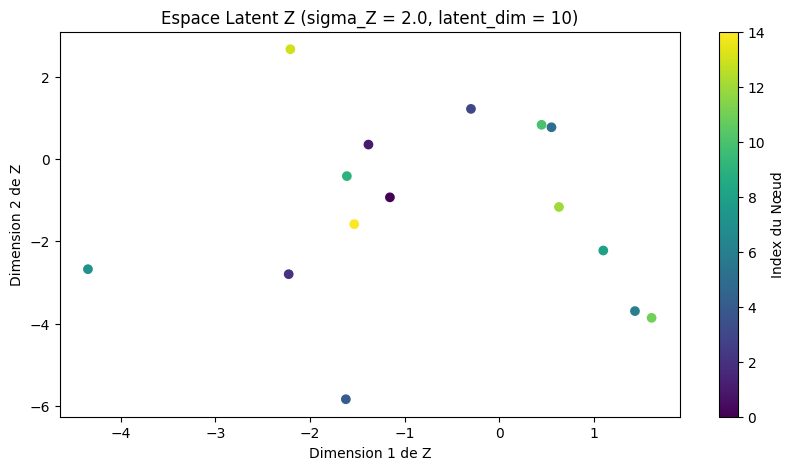

Expérience : latent_dim=10, sigma_Z=2.0, num_nodes=5, num_timesteps=5


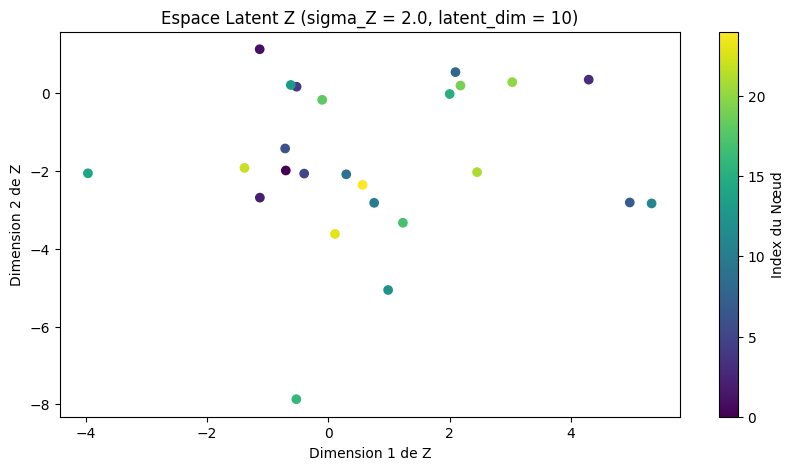

Expérience : latent_dim=10, sigma_Z=2.0, num_nodes=10, num_timesteps=3


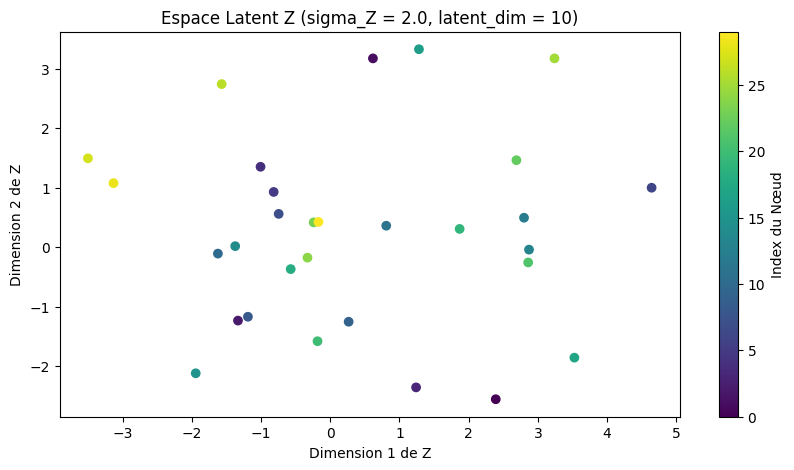

Expérience : latent_dim=10, sigma_Z=2.0, num_nodes=10, num_timesteps=5


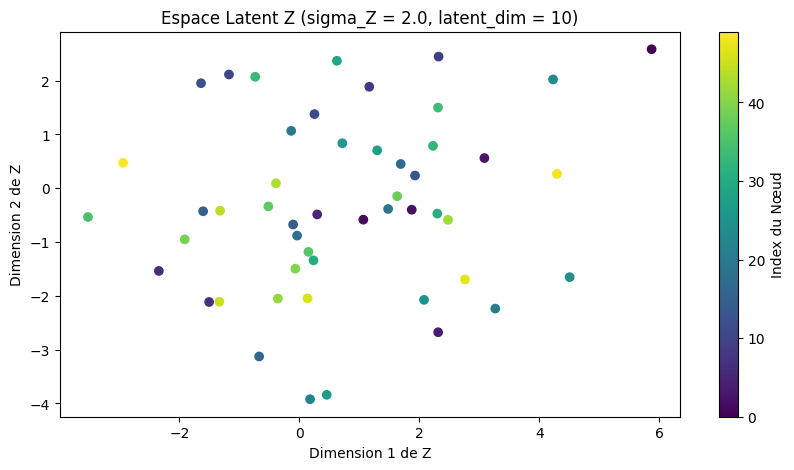

In [15]:
def create_spatiotemporal_graph(num_nodes, num_timesteps, input_dim, mean=0.0, std=1.0):
    # Arêtes spatiales (voisinage géographique)
    edge_index_spatial = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous()
    
    # Arêtes temporelles (évolution dans le temps)
    edge_index_temporal = torch.tensor([[i, i + num_nodes] for i in range(num_nodes * (num_timesteps - 1))], dtype=torch.long).t().contiguous()
    
    # Caractéristiques des nœuds suivant une distribution normale
    x = torch.normal(mean=mean, std=std, size=(num_nodes * num_timesteps, input_dim))
    
    return Data(x=x, edge_index_spatial=edge_index_spatial, edge_index_temporal=edge_index_temporal)

# Fonction pour entraîner et visualiser l'espace latent
def experiment_latent_space(num_nodes, num_timesteps, input_dim, hidden_dim, latent_dim, sigma_Z):
    # Création du graph spatiotemporel
    graph = create_spatiotemporal_graph(num_nodes, num_timesteps, input_dim)
    
    # Initialisation de l'encodeur et du décodeur
    encoder = SpatioTemporalGNN(input_dim, hidden_dim, latent_dim)
    decoder = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))
    
    # Encodage, échantillonnage de Z et décodage
    mu_Z = encoder(graph.x, graph.edge_index_spatial, graph.edge_index_temporal)
    epsilon = torch.randn_like(mu_Z)
    Z = mu_Z + sigma_Z * epsilon  # Échantillonnage de Z
    
    # Visualisation de l'espace latent
    plt.figure(figsize=(10, 5))
    plt.scatter(Z[:, 0].detach().numpy(), Z[:, 1].detach().numpy(), c=range(Z.shape[0]), cmap='viridis')
    plt.colorbar(label='Index du Nœud')
    plt.xlabel('Dimension 1 de Z')
    plt.ylabel('Dimension 2 de Z')
    plt.title(f'Espace Latent Z (sigma_Z = {sigma_Z}, latent_dim = {latent_dim})')
    plt.show()

# Paramètres de base
input_dim = 10
hidden_dim = 16
mean = 0.0
std = 1.0

# Variations des hyperparamètres
latent_dims = [2, 5, 10]  # Différentes dimensions de l'espace latent
sigma_Z_values = [0.5, 1.0, 2.0]  # Différentes valeurs de sigma_Z
num_nodes_values = [5, 10]  # Différents nombres de nœuds spatiaux
num_timesteps_values = [3, 5]  # Différents nombres de pas de temps

# Expériences
for latent_dim in latent_dims:
    for sigma_Z in sigma_Z_values:
        for num_nodes in num_nodes_values:
            for num_timesteps in num_timesteps_values:
                print(f"Expérience : latent_dim={latent_dim}, sigma_Z={sigma_Z}, num_nodes={num_nodes}, num_timesteps={num_timesteps}")
                experiment_latent_space(num_nodes, num_timesteps, input_dim, hidden_dim, latent_dim, sigma_Z)

### Fonction pour générer plusieurs échantillons de Z et calculer la variance des prédictions


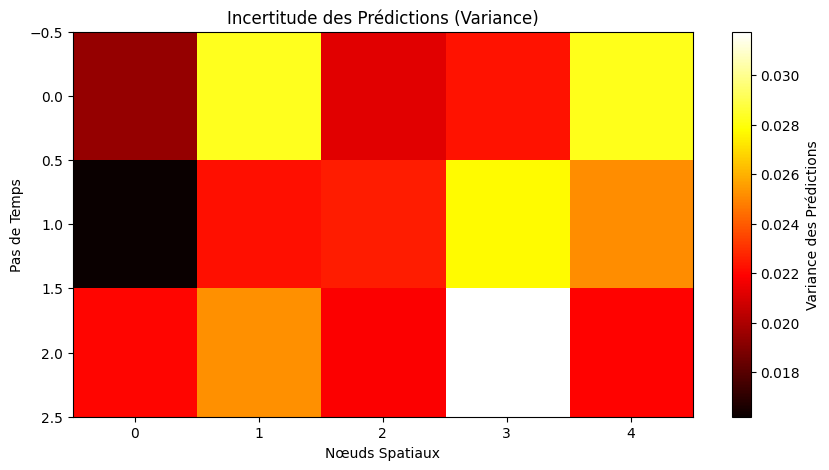

In [24]:

def measure_uncertainty(num_nodes, num_timesteps, input_dim, hidden_dim, latent_dim, sigma_Z, num_samples=100):
    # Création du graph spatiotemporel
    graph = create_spatiotemporal_graph(num_nodes, num_timesteps, input_dim)
    
    # Initialisation de l'encodeur et du décodeur
    encoder = SpatioTemporalGNN(input_dim, hidden_dim, latent_dim)
    decoder = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))
    
    # Stockage des prédictions pour chaque échantillon
    predictions = []
    
    # Génération de plusieurs échantillons de Z
    for _ in range(num_samples):
        mu_Z = encoder(graph.x, graph.edge_index_spatial, graph.edge_index_temporal)
        epsilon = torch.randn_like(mu_Z)
        Z = mu_Z + sigma_Z * epsilon  # Échantillonnage de Z
        output = decoder(Z)  # Prédiction
        predictions.append(output.detach().numpy())
    
    # Convertir en un tableau numpy
    predictions = np.array(predictions)  # Shape: (num_samples, num_nodes * num_timesteps, 1)
    
    # Calculer la variance des prédictions
    variance = np.var(predictions, axis=0)  # Variance le long de l'axe des échantillons
    
    # Remodeler pour correspondre à la structure spatiotemporelle
    variance = variance.reshape(num_timesteps, num_nodes)
    
    return variance

# Paramètres
input_dim = 10
hidden_dim = 16
latent_dim = 5
num_nodes = 5
num_timesteps = 3
sigma_Z = 1.0
num_samples = 100  # Nombre d'échantillons pour mesurer l'incertitude

# Mesurer l'incertitude
variance = measure_uncertainty(num_nodes, num_timesteps, input_dim, hidden_dim, latent_dim, sigma_Z, num_samples)

# Visualisation de la variance des prédictions
def visualize_uncertainty(variance, num_nodes, num_timesteps):
    plt.figure(figsize=(10, 5))
    plt.imshow(variance, cmap='hot', aspect='auto')
    plt.colorbar(label='Variance des Prédictions')
    plt.xlabel('Nœuds Spatiaux')
    plt.ylabel('Pas de Temps')
    plt.title('Incertitude des Prédictions (Variance)')
    plt.show()

# Visualiser la variance
visualize_uncertainty(variance, num_nodes, num_timesteps)

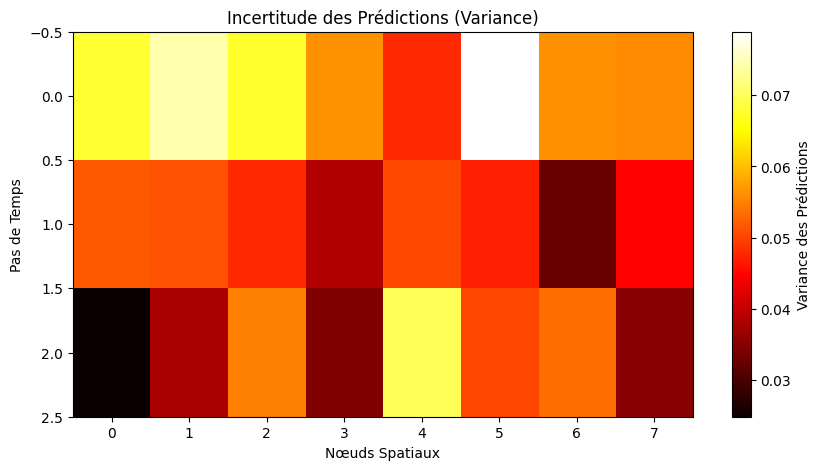

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np

# Encodeur GNN pour un graph hiérarchique
class HierarchicalGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_levels):
        super(HierarchicalGNN, self).__init__()
        self.num_levels = num_levels
        self.conv_spatial = nn.ModuleList([GCNConv(input_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_levels)])
        self.conv_temporal = GCNConv(hidden_dim, latent_dim)  # Convolution temporelle
        
    def forward(self, x, edge_indices):
        # Propagation spatiale à travers les niveaux hiérarchiques
        for i in range(self.num_levels):
            x = F.relu(self.conv_spatial[i](x, edge_indices[i]))
        # Propagation temporelle
        x = self.conv_temporal(x, edge_indices[-1])
        return x

# Création d'un graph hiérarchique
def create_hierarchical_graph(num_nodes, num_timesteps, input_dim, num_levels, mean=0.0, std=1.0):
    # Caractéristiques des nœuds suivant une distribution normale
    x = torch.normal(mean=mean, std=std, size=(num_nodes * num_timesteps, input_dim))
    
    # Arêtes spatiales pour chaque niveau hiérarchique
    edge_indices = []
    for level in range(num_levels):
        # Réduire le nombre de nœuds à chaque niveau
        nodes_at_level = num_nodes // (2 ** level)
        edge_index = torch.tensor([[i, j] for i in range(nodes_at_level) for j in range(nodes_at_level) if i != j], dtype=torch.long).t().contiguous()
        edge_indices.append(edge_index)
    
    # Arêtes temporelles (évolution dans le temps)
    edge_index_temporal = torch.tensor([[i, i + num_nodes] for i in range(num_nodes * (num_timesteps - 1))], dtype=torch.long).t().contiguous()
    edge_indices.append(edge_index_temporal)
    
    return Data(x=x, edge_indices=edge_indices)

# Fonction pour générer plusieurs échantillons de Z et calculer la variance des prédictions
def measure_uncertainty_hierarchical(num_nodes, num_timesteps, input_dim, hidden_dim, latent_dim, sigma_Z, num_levels, num_samples=100):
    # Création du graph hiérarchique
    graph = create_hierarchical_graph(num_nodes, num_timesteps, input_dim, num_levels)
    
    # Initialisation de l'encodeur et du décodeur
    encoder = HierarchicalGNN(input_dim, hidden_dim, latent_dim, num_levels)
    decoder = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))
    
    # Stockage des prédictions pour chaque échantillon
    predictions = []
    
    # Génération de plusieurs échantillons de Z
    for _ in range(num_samples):
        mu_Z = encoder(graph.x, graph.edge_indices)
        epsilon = torch.randn_like(mu_Z)
        Z = mu_Z + sigma_Z * epsilon  # Échantillonnage de Z
        output = decoder(Z)  # Prédiction
        predictions.append(output.detach().numpy())
    
    # Convertir en un tableau numpy
    predictions = np.array(predictions)  # Shape: (num_samples, num_nodes * num_timesteps, 1)
    
    # Calculer la variance des prédictions
    variance = np.var(predictions, axis=0)  # Variance le long de l'axe des échantillons
    
    # Remodeler pour correspondre à la structure spatiotemporelle
    variance = variance.reshape(num_timesteps, num_nodes)
    
    return variance

# Paramètres
input_dim = 10
hidden_dim = 16
latent_dim = 5
num_nodes = 8  # Doit être divisible par 2^num_levels
num_timesteps = 3
sigma_Z = 1.0
num_levels = 2  # Nombre de niveaux hiérarchiques
num_samples = 100  # Nombre d'échantillons pour mesurer l'incertitude

# Mesurer l'incertitude avec un graph hiérarchique
variance = measure_uncertainty_hierarchical(num_nodes, num_timesteps, input_dim, hidden_dim, latent_dim, sigma_Z, num_levels, num_samples)

# Visualisation de la variance des prédictions
def visualize_uncertainty(variance, num_nodes, num_timesteps):
    plt.figure(figsize=(10, 5))
    plt.imshow(variance, cmap='hot', aspect='auto')
    plt.colorbar(label='Variance des Prédictions')
    plt.xlabel('Nœuds Spatiaux')
    plt.ylabel('Pas de Temps')
    plt.title('Incertitude des Prédictions (Variance)')
    plt.show()

visualize_uncertainty(variance, num_nodes, num_timesteps)